# 1. CT이미지 데이터셋 확인

In [1]:
import os
import pandas as pd

In [2]:
data_dir = '../../data/MEDICAL-DATASET/Segmentation/'

#data_df = 이미지 명과 해당 마스크 명을 담아놓은 파일(아이디~_까지는 고객의 고유 번호)
data_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [3]:
# 고객의 아이디만 뽑아서 새로운 컬럼을 추가

def customer_id(x):
    return x.split('_')[0]

data_df['ID'] = data_df['ImageId'].apply(customer_id)

In [4]:
# 고객 데이터 확인
import numpy as np
# 고객 아이디 하나만 담는 array
customer_ids = np.unique(data_df['ID'])


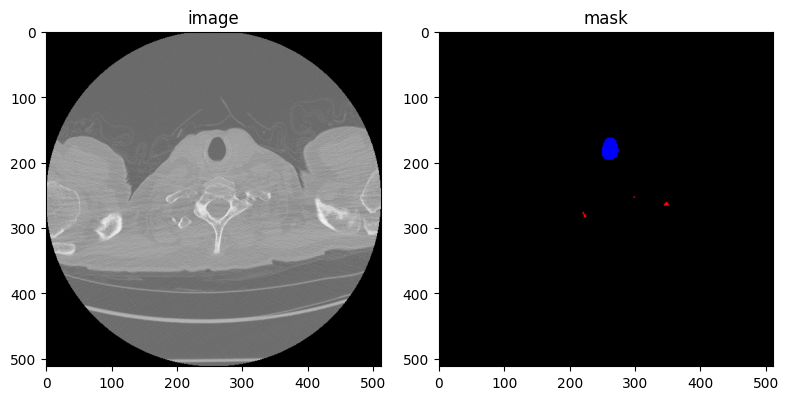

In [5]:
# 이미지 시각화(0번째 고객에 대한 데이터만 불러와서 확인)
import cv2
import matplotlib.pyplot as plt

customer_data = data_df[customer_ids[0]==data_df['ID']][['ImageId','MaskId']]

index = 0
img_name, mask_name = customer_data.iloc[index]
img_path = os.path.join(data_dir,'images' ,img_name)
mask_path = os.path.join(data_dir,'masks' ,mask_name)
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

#데이터가 어그러진 부분 전처리
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(img)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [6]:
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255))

In [10]:
# 고객 아이디에 따른 데이터들을 영상으로 확인

def customer_data(data_df, index):
    customer_ids = np.unique(data_df['ID'])
    customer_data = data_df[customer_ids[index]==data_df['ID']]
    img_file_list = list(customer_data['ImageId'])
    mask_file_list = list(customer_data['MaskId'])

    return img_file_list, mask_file_list


index = 0
img_file_list, mask_file_list = customer_data(data_df, index)
canvas = np.zeros(shape=(512,2*512+50,3), dtype = np.uint8)

for i in range(len(img_file_list)):
    img = cv2.imread(os.path.join(data_dir,'images',img_file_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_file_list[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255

    #간격 지정
    grid_pad = 50

    #컨버스에 이미지 그려줌 
    canvas[:, :512, :] = img
    canvas[:, 512+grid_pad:, :] = mask

    # mask색 별 이미지 정보 글자로 표시
    text_buff = 410
    for label in range(1, len(regions)):
        # (캔버스 , 문구, 위치(x,y), 폰트, 크기, 색, 두께)
        cv2.putText(canvas, f'{regions[label]}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 2)
        text_buff+=40

    cv2.imshow('CT Data', canvas)

    # 사용자의 키보드입력을 기다림(0.06초) - for 문을 돌 때 0.06초를 기다려서 사용자가 esc를 누르면 brake아니라면 for문이 계속 돌아감
    # 프레임 지정과 같음
    key = cv2.waitKey(60)
    if key == 27:
        break

#for문을 다 돌면 윈도우 종료
cv2.destroyAllWindows() 

# 2. 데이터셋, 데이터 로더 구축, 텐서로 변환 

### 주의
1. jpeg의 경우 png와 다르게 엣지의 픽셀이 뭉개지는 부분을 확인해야함
2. 이미지나 마스크의 resize를 할 때 이미지의 경우 INTER_LINEAR같은 보간법을 사용해도 되지만 마스크는 linear한 보간법을 쓸 수 없고 INTER_NEAREST와 같은 비선형으로 해야함

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

In [8]:
# 데이터셋 구축
class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir,'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.phase = phase #train과 val등에 따라서 transformer를 다르게 할 때 사용

        #데이터들 이름을 담는 리스트
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)

        # img파일의 수와 mask파일의 수를 비교(일치시키는것이 중요), 다를 경우 오류 및 프로그램 종료
        assert len(self.img_files) == len(self.mask_files)

        self.transformer = transformer

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index): 
        img = cv2.imread(os.path.join(self.img_dir, self.img_files[index]))
        img = cv2.resize(img, dsize=(224,224))
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(224,224))

        # 마스크 이미지 픽셀 뭉개진 부분 처리
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        # 마스크 노멀라이즈
        mask = mask / 255

        H, W, c = mask.shape
        background = np.ones((H,W,1))
        # 4개의 채널을 합쳐서 argmax해 큰 인덱스 값을 mask에 넣어주기 위해서 label이 있는곳은 0 없는곳은 1로 해주는거임, 그래야 argmax하면 배경 부분을 인식해
        background[mask[:,:,0] != 0] = 0
        background[mask[:,:,1] != 0] = 0
        background[mask[:,:,2] != 0] = 0
        mask = np.concatenate([background, mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False) #keepdims True일 경우 argmax어도 채널이 압축되지않음
        

        if self.transformer:
            img = self.transformer(img)
        mask = torch.from_numpy(mask).long()

        return img, mask
    

In [9]:
# trasformer 구현 텐서로 변환
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    return transformer

In [10]:
# collate함수 구현(예) - 단순 B,C,H,W의 형태로 데이터를 구성해주는 함수
# 배치형테로 구성이 될 때 배치의 구성형태(이미지,라벨 등을 어떤형태로)를 세밀하게 조절해줄 수 있음
# 데이터 로더를 위함
def make_collate_fn(batch):
    imgs = []
    masks = []
    for i, m in batch:
        imgs.append(i)
        masks.append(m)
    imgs = torch.stack(imgs, dim=0)
    masks = torch.stack(masks, dim=0)
    
    return imgs, masks
        

In [11]:
data_dir = '../../data/MEDICAL-DATASET/Segmentation'

In [12]:
def CT_dataloader(data_dir, batch):
    tranformer = build_transformer()
    dataloaders = {}

    train_dir = os.path.join(data_dir,'train')
    train_dataset = CT_dataset(train_dir,'train',tranformer)
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn = make_collate_fn)

    val_dir = os.path.join(data_dir,'val')
    train_dataset = CT_dataset(val_dir,'val',tranformer)
    dataloaders['val'] = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn = make_collate_fn)

    return dataloaders

In [13]:
dataloaders = CT_dataloader(data_dir,4)

In [14]:
for i in dataloaders['train']:
    print(i[1].shape) #마스크는 채널이 없어(있는데 DataSet에서 하나로 합침)
    break

torch.Size([4, 224, 224])


# 3. U-Net 구현

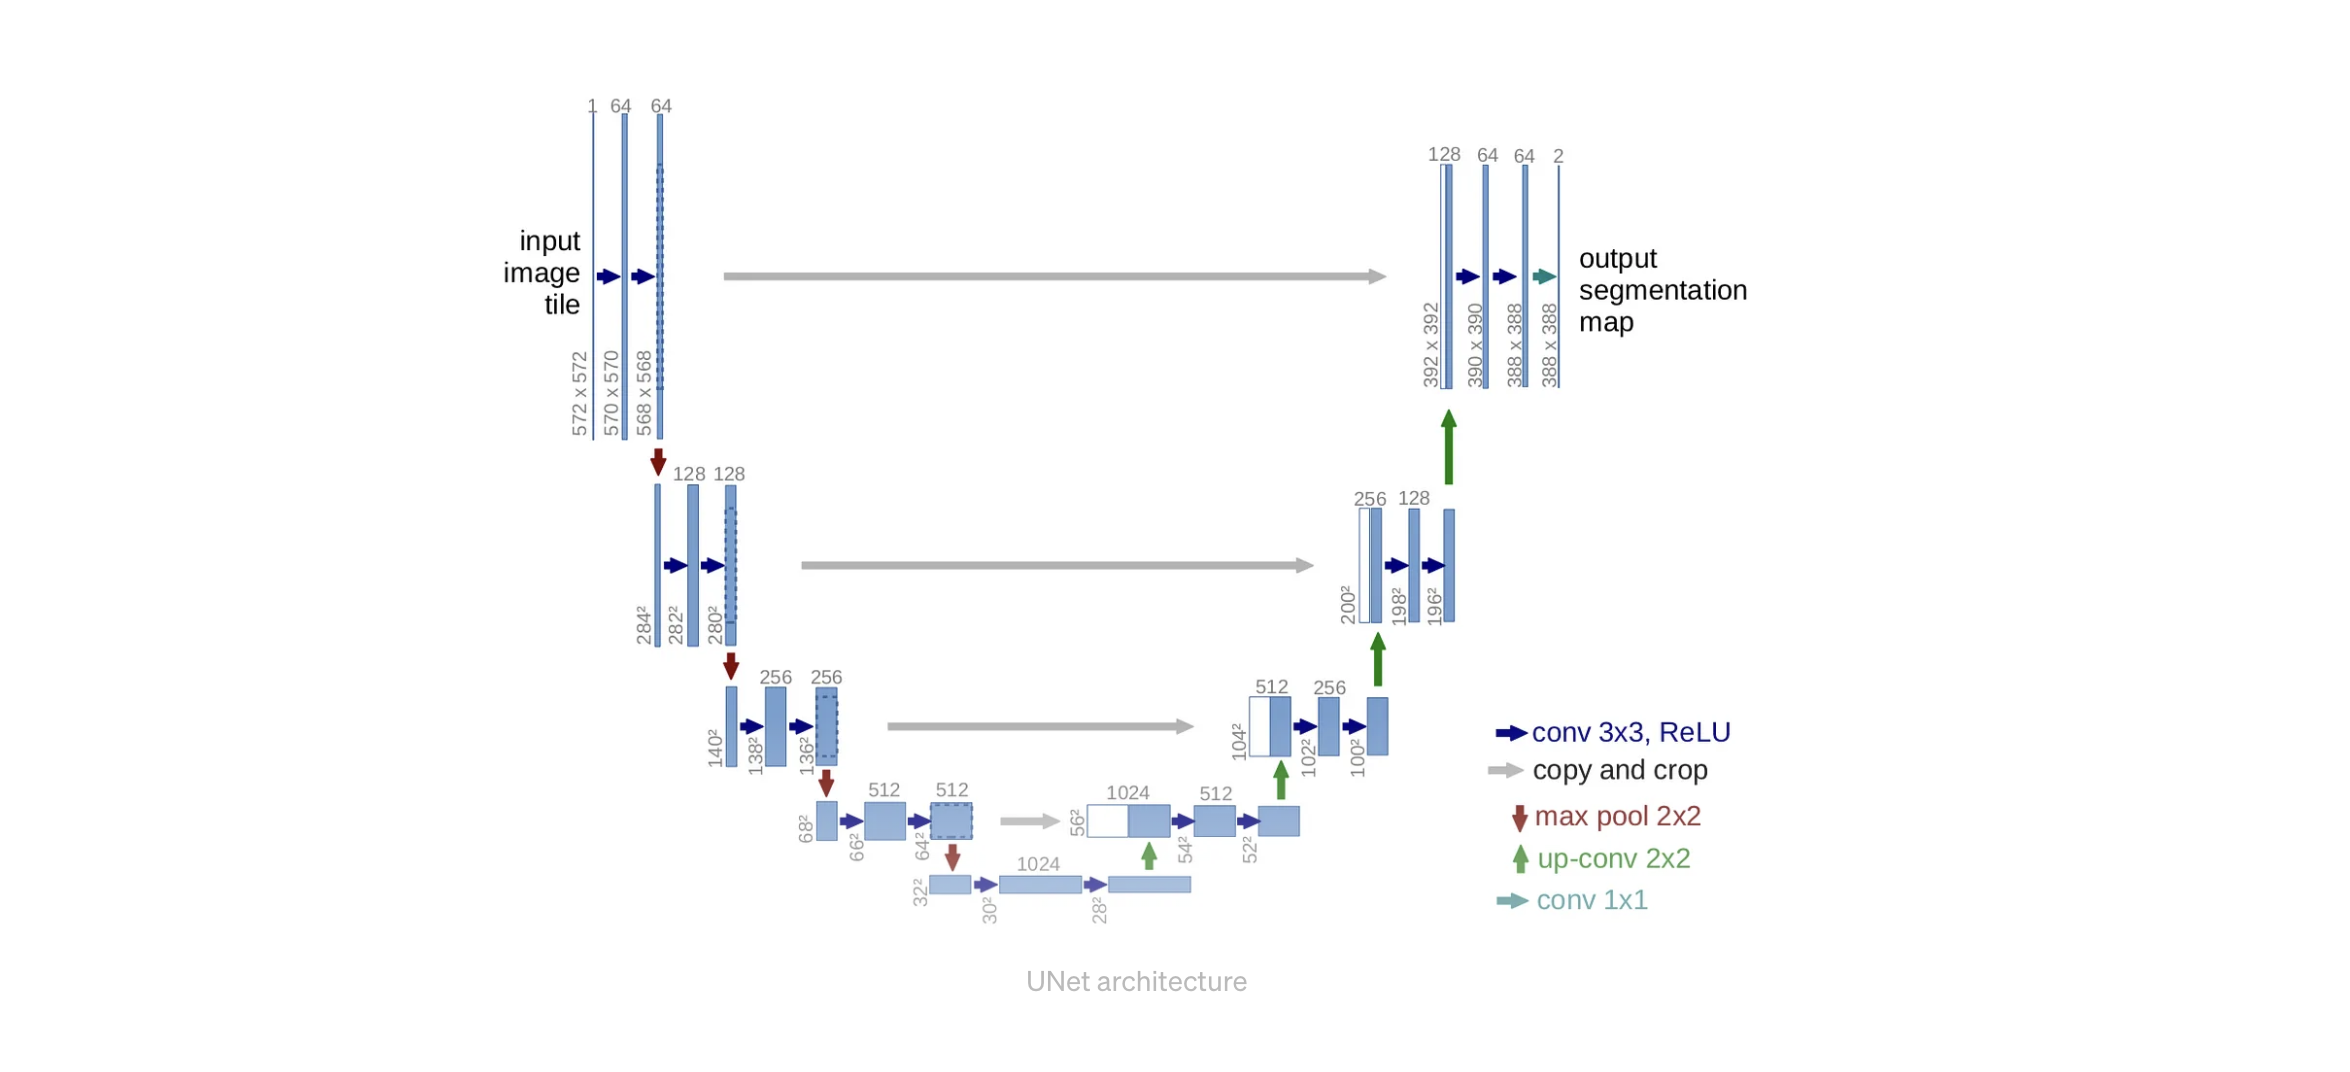

In [15]:
import torch
import torch.nn as nn

In [16]:
# 파란색 화살표(convolution 연산)
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True), #함수가 적용된 출력을 새로운 변수에 할당하는 대신 원래의 변수에 직접 덮어

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels), # 두 과정 모두 같은 채널을 반환하기 때문에 한 번에 구현
        nn.ReLU(inplace=True)
    )
    return layers
        

In [17]:
#Encoder구현
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pooling = nn.MaxPool2d(kernel_size=2)

    def forward(self, img):
        skip_connection = [] #skip connection를 위해서 각 conv마다 feature를 가져와야함(pooling전)
        out = self.conv_block1(img)
        skip_connection.append(out)
        out = self.pooling(out)

        out = self.conv_block2(out)
        skip_connection.append(out)
        out = self.pooling(out)

        out = self.conv_block3(out)
        skip_connection.append(out)
        out = self.pooling(out)

        out = self.conv_block4(out)
        skip_connection.append(out)
        out = self.pooling(out)

        out = self.conv_block5(out)

        return out, skip_connection
    

In [18]:
# 랜덤 데이터를 이용해서 resoluiton확인
encoder = Encoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
for ftr in ftrs:
    print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [19]:
# 디코더의 upconv(초록색)
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers
        

In [20]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512) #skipconnection에서 받아온 512짜리 데이터를 합쳐서(그림의 흰색부분) 사용하기 때문에 512+512()

        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)

        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)

        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)

    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out

    

In [21]:
# 랜덤으로 확인
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [22]:
import torch.nn.functional as F

In [23]:
# U-Net구현
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64,num_classes, kernel_size=1) # 마지막 청록색 화살표 구현
        self.retain_input_dim = retain_input_dim

    def forward(self, x):
        out , encoder_feature = self.encoder(x)
        out = self.decoder(out, encoder_feature)
        out = self.head(out)

        if self.retain_input_dim:#output의 shape이 원래 input의 데이터와 같이 복원이 잘 되도록
            _,_,H,W = x.shape
            out = F.interpolate(out, size=(H,W)) #이미지 보간

        return out 


In [24]:
model = UNet(num_classes=4)# 배경, 폐, 기도 , 심장이라 4개

In [25]:
#shape확인
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 4, 224, 224])


# 4. Dice similarity coefficient 구현

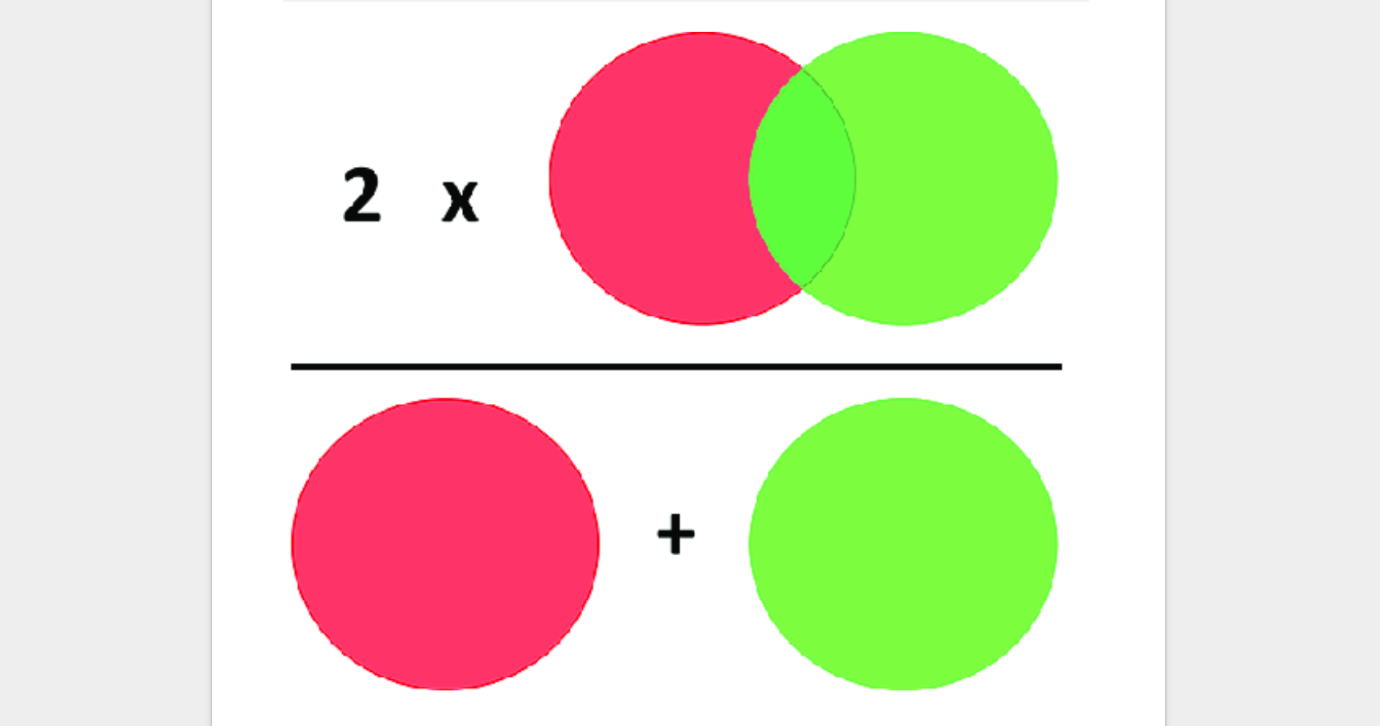

In [26]:
# dice coeff , loss 구하는 법
# 모델을 통과한 예측값을 argmax(타겟값이 argmax되어있음) -> 타겟 및 예측 원핫인코딩, 재배열 -> 각 채널마다 coeff구하기 : 2*교집합/ 두 값의 합 -> class에따른 평균

num_classes = 4
# 예측값 하나 뽑아내기
for index, batch in enumerate(dataloaders['train']):
    img = batch[0]
    target = batch[1]
    prediction = model(img)

    break

# 예측값 argmax -> 채널 중 가장 큰 값에 대한 인덱스를 뽑아줌
prediction_ = torch.argmax(prediction, dim=1)

#원핫인코딩 및 재배열, permute는 차원을 재배열 one_hot을 하면 4,224,224,4로 원핫인코딩 되고, 이것을 4,4,224,224로 변환
oh_traget = F.one_hot(target,num_classes=num_classes).permute(0,3,1,2)
oh_prediction = F.one_hot(prediction_,num_classes=num_classes).permute(0,3,1,2)

# 한개의 배치에 대해서 coeff구하기
oh_traget_ = oh_traget[0]
oh_prediction_ = oh_prediction[0]

dice_coeff = 0
for class_idx in range(1, num_classes): #classindex0은 background, background에 대애선 dice coeff 계산 필요x
    a = oh_traget_[class_idx]
    b = oh_prediction_[class_idx]

    #원핫 인코딩 되어있기 때문에 둘을 자리에 따라 곱하면 동일한 값을 갖는 위치만 1 합하면 그것이 교집합
    inter = torch.sum(a.reshape(-1).float()*b.reshape(-1).float()) 
    set_sum = a.sum()+b.sum()

    dice_coeff += (2*inter)/(set_sum + 1e-9) # 1e-9는 분모가 0이되는것을 방지
  
dice_coeff/=(num_classes-1)    # classid별로 누적이 되어서 평균을 구해줌
dice_loss = 1.-dice_coeff

# 6. LossFunction 구현

#### 2가지의 loss를 혼합해서 사용 할 것이기 때문에 위의 dice를 구하는 방법을 이용해 UNet_Metric을 생성-> dice loss를 batch에 적용하기 위함
1. dice loss
2. cross entropy

In [27]:
class UNet_Metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean") # cross entropy : mean - minibatch 4개의 평균

    # pred는 argmax가 된 상태
    def __call__(self, pred, target): # 객체가 생성될 때 실행되는 함수 -> 최종적인 batch에서의 평균 dice값을 반환
        #원 핫 인코딩을 한 후 batch에서 dice를 구하는 함수에 전달
        oh_traget = F.one_hot(target,num_classes=num_classes).permute(0,3,1,2)
        oh_prediction = F.one_hot(torch.argmax(pred, dim=1),num_classes=num_classes).permute(0,3,1,2)

        dice_coefficient = self.batch_dice(oh_prediction,oh_traget)
        dice_loss = 1.-dice_coefficient
        cross_loss = self.CE_loss(pred, target)
        total_loss = dice_loss+cross_loss

        return total_loss, dice_coefficient
        

    def batch_dice(self, pred, target):
        batch_dice = 0
        batch = target.shape[0]
        for mini in range(batch):
            batch_dice += self.one_minibatch_dice(pred[mini], target[mini])
        
        return batch_dice/batch # 배치에 대한 평균 dice
            
    
    
    def one_minibatch_dice(self,pred, target):        
        class_dice = 0
        for class_idx in range(1, self.num_classes): #classindex0은 background, background에 대애선 dice coeff 계산 필요x
            a = pred[class_idx]
            b = target[class_idx]
        
            #원핫 인코딩 되어있기 때문에 둘을 자리에 따라 곱하면 동일한 값을 갖는 위치만 1 합하면 그것이 교집합
            inter = torch.sum(a.reshape(-1).float()*b.reshape(-1).float()) 
            set_sum = a.sum()+b.sum()
            if set_sum.item() == 0: # 두가지 영역에 대한 합이 0일때 
                set_sum = 2 * inter # 분모 분자의 값을 동일하게 
        
            class_dice += (2*inter)/(set_sum + 1e-9) # 1e-9는 분모가 0이되는것을 방지
          
        return class_dice/(self.num_classes-1) # classid별 평균
        
        

In [28]:
criterion = UNet_Metric(num_classes=4)
criterion(prediction, target)
#dice_coeff 는 accuracy같은 역할

(tensor(2.6602, grad_fn=<AddBackward0>), tensor(0.0056))

# 7. SGDM 

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

# 8. 모델 학습

In [30]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):

    losses={}
    dice_coefficients = {}

    for ty in ['train','val']:
        running_loss = 0.0
        running_dice = 0.0
        
        if ty=='train':
            model.train()
        else :
            model.eval()

        for idx, batch in enumerate(dataloaders[ty]):
            img = batch[0].to(device)
            mask = batch[1].to(device)

            with torch.set_grad_enabled(ty=='train'): #train일때만 grad갱신
                prediction = model(img)
                batch_loss, batch_dice = criterion(prediction, mask)

                if ty=='train':
                    optimizer.zero_grad()
                    batch_loss.backward()
                    optimizer.step()

                    if idx%100 == 0:
                        print(f"batch:{idx}/{len(dataloaders[ty])}, loss:{batch_loss.item()}, dice:{batch_dice.item()}")

                running_loss += batch_loss.item()
                running_dice += batch_dice.item()

        losses[ty] = running_loss/len(dataloaders[ty]) # 한 에폭 크기의 평균 loss
        dice_coefficients[ty] = running_dice/len(dataloaders[ty]) # 한 에폭 크기의 평균 dice


    return losses, dice_coefficients               
                
    

In [31]:
#모델 저장
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [32]:
data_dir = '../../data/MEDICAL-DATASET/Segmentation/'
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 100
DEVICE = torch.device('cpu')

dataloaders = CT_dataloader(data_dir,4)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_Metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [33]:
epochs = 5
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coefficient = [], []
val_loss, val_dice_coefficient = [], []

for epoch in range(epochs):
    epoch_loss, epoch_dice = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)

    train_loss.append(epoch_loss['train'])
    train_dice_coefficient.append(epoch_dice['trian'])
    val_loss.append(epoch_loss['val'])
    val_dice_coefficient.append(epoch_dice['val'])

    print(f'{epoch}/{epochs} - train loss : {train_loss}, val loss : {val_loss}')
    print(f'{epoch}/{epochs} - train dice : {train_dice_coefficient}, val dice : {val_dice_coefficient}')

    if epoch_dice['val'] > best_score:
        best_score = epoch_dice['val']
        save_best_model(model.state_dict(), 'best_model')

print(f'Best Score(dice) : {best_score}')

batch:0/3728, loss:2.391380786895752, dice:0.0010447259992361069


KeyboardInterrupt: 

# 9. 모델 테스트 및 Morphological filtering 적용

In [33]:
# 학습된 모델 불러오는 함수
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval() # 테스트 모드로 
    return model


### morpholocal 
#### 예측값이 픽셀단위로 나타나기 때문에 산발적으로 나타나있는 경우를 없애주기위함
#### opening, closing 두가지의 방법이 있음
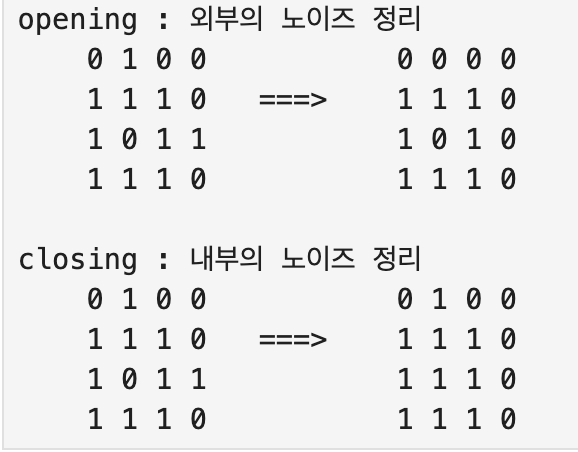

In [38]:
# 예측값이 픽셀단위로 나타나기 때문에 산발적으로 나타나있는 경우를 없애주기위함(closing을 이용)
def morpholocal_process(mask, num_classes, ksize=7):
    new_mask = mask.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(ksize, ksize)) #모폴로지에 사용될 커널을 사각형 모양의 7,7로 생성

    for class_index in range(1, num_classes):
        binary_mask = (mask == class_index).astype(np.uint8) #mask와 class_index가 일치하는 곳만 True로 1,0의 값으로 변경하기 위함
        closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel) # 1들 사이에 0이 있는 부분 closing처리
        new_mask[closing.astype(np.bool_)] = class_index # closing된 1,0값을 bool값으로 바꿔서 True인 부분을 원래의 label로
    return new_mask

In [39]:
def ToRGB(mask, num_classes): # 마스크 데이터를 RGB로 변환
    CLASS_ID = {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255)}
    mask_H, mask_W = mask.shape
    R_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    G_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    B_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)

    for class_index in range(1, num_classes): # 백그라운드는 빼고, label이 1인경우
        R_channel[mask == class_index] = CLASS_ID[class_index][0] #255
        G_channel[mask == class_index] = CLASS_ID[class_index][1] #0
        B_channel[mask == class_index] = CLASS_ID[class_index][2] #0의 값을 가지는 3개의 채널만들어줌(모든 데이터에 대해서 각 label에 맞게 값을 변경)

    RGB_mask = cv2.merge((B_channel, G_channel, R_channel))
    return RGB_mask

In [45]:
from PIL import Image

In [40]:
@torch.no_grad() # test는 grad를 계산하지 않기 때문에 메모리 절약의 이유로 사용됨
def predict_segment(image, model, num_classes):
    PIL_image = Image.fromarray(image) #array를 이미지로
    tensor_image = transformer(PIL_image)

    pred_mask = model(torch.unsqueeze(tensor_image, dim=0)) # tensor를 batch형태로(C,H,W) -> (1,C,H,W)
    pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0) # tensor를 batch형태로(1,C,H,W) -> (C,H,W)
    pred_mask = pred_mask.numpy()
    pred_mask = morpholocal_process(pred_mask, num_classes)
    rgb_mask = ToRGB(pred_mask, num_classes)
    return rgb_mask

In [41]:
# 학습된 모델 불러와서 사용
ckpt_path = "./trained_model/model_05.pth"
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # 학습이랑 맞춰줘야함

In [46]:
#video데이터를 가져와 값을 확인

video_path = '../../data/MEDICAL-DATASET/Segmentation/video/test/ID00400637202305055099402.mp4'

cnt = 0
vidcap = cv2.VideoCapture(video_path) #프레임을 읽기 위해 비디오를 불러옴
while (vidcap.isOpened()):
    ret, frame = vidcap.read() #ret:프레임이 성공적으로 읽혔는지의 불리안값

    if ret:
        rgb_mask = predict_segment(frame, model, NUM_CLASSES)
        rgb_mask = cv2.resize(rgb_mask, dsize=frame.shape[:2]) # 원본사이즈의 크기로 

        alpha = 0.6 # alpha:각 이미지의 가중치를 조절하는 매개변수로, 값이 작을수록 해당 이미지의 투명도가 높아짐
        blend = cv2.addWeighted(frame, alpha, rgb_mask, 1-alpha, 0) #프레임과 마스크를 하나의 이미지로
        cv2.imshow('output', blend)

        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'): #'s'키를 눌러 영상을 멈추는 기능
            cv2.waitKey(0)
    else:
        break

vidcap.release()
cv2.destroyAllWindows()